In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib import pyplot as plt
import warnings

In [2]:
warnings.filterwarnings(action='ignore',category=FutureWarning)

In [3]:
pd.set_option('display.max_columns', None)
df = pd.read_csv("Manhattan12.csv", skiprows=4)
df.head(5)

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APART\nMENT\nNUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE\nPRICE,SALE DATE
0,1,,13 CONDOS - ELEVATOR APARTMENTS,,738,1306,,,345 WEST 14TH STREET,,10014,0,0,0,0,0,0,2,R4,"$2,214,693",20/05/2013
1,1,,13 CONDOS - ELEVATOR APARTMENTS,,738,1307,,,345 WEST 14TH STREET,,10014,0,0,0,0,0,0,2,R4,"$1,654,656",16/05/2013
2,1,,13 CONDOS - ELEVATOR APARTMENTS,,738,1308,,,345 WEST 14TH STREET,,10014,0,0,0,0,0,0,2,R4,"$1,069,162",23/05/2013
3,1,,13 CONDOS - ELEVATOR APARTMENTS,,738,1309,,,345 WEST 14TH STREET,,10014,0,0,0,0,0,0,2,R4,"$1,374,637",15/05/2013
4,1,,13 CONDOS - ELEVATOR APARTMENTS,,738,1310,,,345 WEST 14TH STREET,,10014,0,0,0,0,0,0,2,R4,"$1,649,565",13/05/2013


In [4]:
# Dtype conversion
df.columns = df.columns.str.strip().str.replace("\n", "")

def format_and_convert_column_to_numeric(col, dtype):
    df[col] = df[col].str.replace(",","").str.replace("$","").astype(dtype)
    
format_and_convert_column_to_numeric('SALEPRICE', np.int64)
format_and_convert_column_to_numeric('GROSS SQUARE FEET', np.float64)
format_and_convert_column_to_numeric('LAND SQUARE FEET', np.float64)
format_and_convert_column_to_numeric('RESIDENTIAL UNITS', np.int64)
format_and_convert_column_to_numeric('TOTAL UNITS', np.int64)

# Convert To datetime
df['SALE DATE'] =pd.to_datetime(df['SALE DATE'], dayfirst=True)

df['YEAR BUILT'] = df['YEAR BUILT'].astype(np.int64)

In [5]:
df.columns = df.columns.str.replace("\n", "").str.replace(" ", "_")
df.rename(columns={"SALEPRICE": "SALE_PRICE", "APARTMENTNUMBER": "APARTMENT_NUMBER"}, inplace=True)
df.columns = df.columns.str.lower()

In [6]:
categorical = df.select_dtypes(include='object').columns.tolist()
numerical = df.select_dtypes(include=['int', 'float']).columns.tolist()

In [7]:
df[categorical] = df[categorical].apply(lambda x: x.str.strip())
df.replace("", np.nan, inplace=True)
df.replace(0, np.nan, inplace=True)
df.isna().sum() / len(df) * 100

borough                             0.000000
neighborhood                        0.062055
building_class_category            12.608140
tax_class_at_present                0.521993
block                               0.000000
lot                                 0.000000
ease-ment                         100.000000
building_class_at_present           0.521993
address                             0.000000
apartment_number                   53.184888
zip_code                            0.003650
residential_units                  59.762730
commercial_units                   87.468516
total_units                        35.422522
land_square_feet                   83.613798
gross_square_feet                  84.208797
year_built                         23.511590
tax_class_at_time_of_sale           0.000000
building_class_at_time_of_sale      0.000000
sale_price                         27.716737
sale_date                           0.000000
dtype: float64

In [8]:
df.dropna(subset=['year_built'], how='any', inplace=True)

In [9]:
df['sale_year'] = pd.DatetimeIndex(df.sale_date).year
df['sale_month'] = pd.DatetimeIndex(df.sale_date).month
df['building_age'] = 2013 - df['year_built']

In [10]:
df.drop(columns=['borough', 'address', 'ease-ment', 'apartment_number', 'sale_date', 'year_built'], inplace=True)


In [11]:
categorical = df.select_dtypes(include='object').columns.tolist()
numerical = df.select_dtypes(include=['int', 'float']).columns.tolist()
print("Categorical columns: ", categorical)
print("Numerical columns: ", numerical)

Categorical columns:  ['neighborhood', 'building_class_category', 'tax_class_at_present', 'building_class_at_present', 'building_class_at_time_of_sale']
Numerical columns:  ['block', 'lot', 'zip_code', 'residential_units', 'commercial_units', 'total_units', 'land_square_feet', 'gross_square_feet', 'tax_class_at_time_of_sale', 'sale_price', 'sale_year', 'sale_month', 'building_age']


In [12]:
df.describe()

,block,lot,zip_code,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,tax_class_at_time_of_sale,sale_price,sale_year,sale_month,building_age
count,20954.000000,20954.000000,20954.000000,8624.000000,3274.000000,11738.000000,4320.000000,4.319000e+03,20954.000000,1.628700e+04,20954.000000,20954.000000,20954.000000
mean,1125.502338,568.544669,10029.774363,5.295686,3.088577,4.808059,5923.381481,6.063457e+04,2.282285,2.788147e+06,2012.532500,7.153002,59.919443
std,492.073441,791.773978,35.391957,26.154578,12.986706,23.759930,7877.044375,8.116691e+04,0.748000,2.095445e+07,0.498955,3.465957,37.692641
min,7.000000,1.000000,10001.000000,1.000000,1.000000,1.000000,469.000000,2.530000e+02,1.000000,1.000000e+00,2012.000000,1.000000,0.000000
25%,851.000000,27.000000,10014.000000,1.000000,1.000000,1.000000,2093.750000,6.196000e+03,2.000000,4.230000e+05,2012.000000,4.000000,26.000000
50%,1140.000000,52.000000,10021.000000,1.000000,2.000000,1.000000,5508.000000,2.331000e+04,2.000000,7.700000e+05,2013.000000,7.000000,58.000000
75%,1444.000000,1111.000000,10028.000000,1.000000,2.000000,2.000000,7532.000000,1.128500e+05,2.000000,1.675000e+06,2013.000000,10.000000,93.000000
max,2250.000000,9117.000000,10463.000000,1328.000000,604.000000,1349.000000,213650.000000,1.970736e+06,4.000000,1.307965e+09,2013.000000,12.000000,1013.000000


In [13]:
# impute = df[['residential_units', 'commercial_units', 'total_units']]
# impute[(impute['residential_units'] + impute['commercial_units'] == impute['total_units']) & ((impute['residential_units'] != np.nan) & (impute['commercial_units'] != np.nan))]

In [14]:
min_values = df[numerical].min()

In [15]:
min_values

block                            7.0
lot                              1.0
zip_code                     10001.0
residential_units                1.0
commercial_units                 1.0
total_units                      1.0
land_square_feet               469.0
gross_square_feet              253.0
tax_class_at_time_of_sale        1.0
sale_price                       1.0
sale_year                     2012.0
sale_month                       1.0
building_age                     0.0
dtype: float64

In [16]:
df[(df['sale_price'] < 500000) & df['sale_price']]

,neighborhood,building_class_category,tax_class_at_present,block,lot,building_class_at_present,zip_code,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,tax_class_at_time_of_sale,building_class_at_time_of_sale,sale_price,sale_year,sale_month,building_age
17,ALPHABET CITY,NaN,4,384,1401,RK,10009.0,NaN,NaN,1.0,NaN,NaN,4,RK,360000.0,2013,6,5.0
24,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,385,1,C7,10009.0,7.0,1.0,8.0,2093.0,5852.0,2,C7,283.0,2013,4,16.0
47,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,373,49,C6,10009.0,NaN,NaN,NaN,NaN,NaN,2,C6,355000.0,2012,10,93.0
48,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,373,49,C6,10009.0,NaN,NaN,NaN,NaN,NaN,2,C6,294500.0,2012,11,93.0
49,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,373,49,C6,10009.0,NaN,NaN,NaN,NaN,NaN,2,C6,244000.0,2013,3,93.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27362,WASHINGTON HEIGHTS UPPER,13 CONDOS - ELEVATOR APARTMENTS,2,2179,1048,R4,10040.0,1.0,NaN,1.0,NaN,NaN,2,R4,320000.0,2013,6,26.0
27363,WASHINGTON HEIGHTS UPPER,13 CONDOS - ELEVATOR APARTMENTS,2,2179,1057,R4,10040.0,1.0,NaN,1.0,NaN,NaN,2,R4,240000.0,2012,12,26.0
27364,WASHINGTON HEIGHTS UPPER,13 CONDOS - ELEVATOR APARTMENTS,2,2179,1079,R4,10040.0,1.0,NaN,1.0,NaN,NaN,2,R4,390000.0,2012,8,26.0
27370,WASHINGTON HEIGHTS UPPER,15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,2180,1103,R1,10033.0,1.0,NaN,1.0,NaN,NaN,2,R1,10.0,2013,3,10.0


In [17]:
df['sale_price'].describe()

count    1.628700e+04
mean     2.788147e+06
std      2.095445e+07
min      1.000000e+00
25%      4.230000e+05
50%      7.700000e+05
75%      1.675000e+06
max      1.307965e+09
Name: sale_price, dtype: float64

In [18]:
df = df[(df['sale_price'] > 500000) & (df['sale_price'] < 15000000)]

In [19]:
df.describe()

,block,lot,zip_code,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,tax_class_at_time_of_sale,sale_price,sale_year,sale_month,building_age
count,10824.000000,10824.000000,10824.000000,5088.00000,622.000000,5439.000000,1197.000000,1198.000000,10824.000000,1.082400e+04,10824.000000,10824.000000,10824.000000
mean,1095.117332,630.120565,10030.689394,3.71305,2.180064,3.742967,3773.412698,13788.119366,2.045732,1.969779e+06,2012.577236,6.926552,63.435976
std,515.128244,841.066428,38.862665,10.59690,3.445418,10.529863,5648.621404,29137.583359,0.405584,2.106661e+06,0.494021,3.312745,35.516260
min,11.000000,1.000000,10001.000000,1.00000,1.000000,1.000000,469.000000,999.000000,1.000000,5.019300e+05,2012.000000,1.000000,0.000000
25%,752.500000,25.000000,10013.000000,1.00000,1.000000,1.000000,1717.000000,4000.000000,2.000000,7.400000e+05,2012.000000,4.000000,32.000000
50%,1171.000000,64.500000,10022.000000,1.00000,1.000000,1.000000,2342.000000,7277.500000,2.000000,1.180000e+06,2013.000000,7.000000,66.000000
75%,1448.000000,1130.250000,10028.000000,1.00000,2.000000,1.000000,3600.000000,13030.500000,2.000000,2.240150e+06,2013.000000,10.000000,93.000000
max,2246.000000,9008.000000,10463.000000,334.00000,60.000000,334.000000,88940.000000,538213.000000,4.000000,1.490000e+07,2013.000000,12.000000,213.000000


In [20]:
df.dropna(subset=categorical, how='any', inplace=True)

In [21]:
df.drop_duplicates(inplace=True)

In [22]:

df.columns

Index(['neighborhood', 'building_class_category', 'tax_class_at_present',
       'block', 'lot', 'building_class_at_present', 'zip_code',
       'residential_units', 'commercial_units', 'total_units',
       'land_square_feet', 'gross_square_feet', 'tax_class_at_time_of_sale',
       'building_class_at_time_of_sale', 'sale_price', 'sale_year',
       'sale_month', 'building_age'],
      dtype='object')

In [23]:
df.drop(columns=['building_class_at_present', 'tax_class_at_present', 'tax_class_at_time_of_sale', 'building_class_at_time_of_sale', 'total_units'], inplace=True)

In [24]:
categorical = df.select_dtypes(include='object').columns.tolist()
numerical = df.select_dtypes(include=['int', 'float']).columns.tolist()
print("Categorical columns: ", categorical)
print("Numerical columns: ", numerical)

Categorical columns:  ['neighborhood', 'building_class_category']
Numerical columns:  ['block', 'lot', 'zip_code', 'residential_units', 'commercial_units', 'land_square_feet', 'gross_square_feet', 'sale_price', 'sale_year', 'sale_month', 'building_age']


<AxesSubplot: >

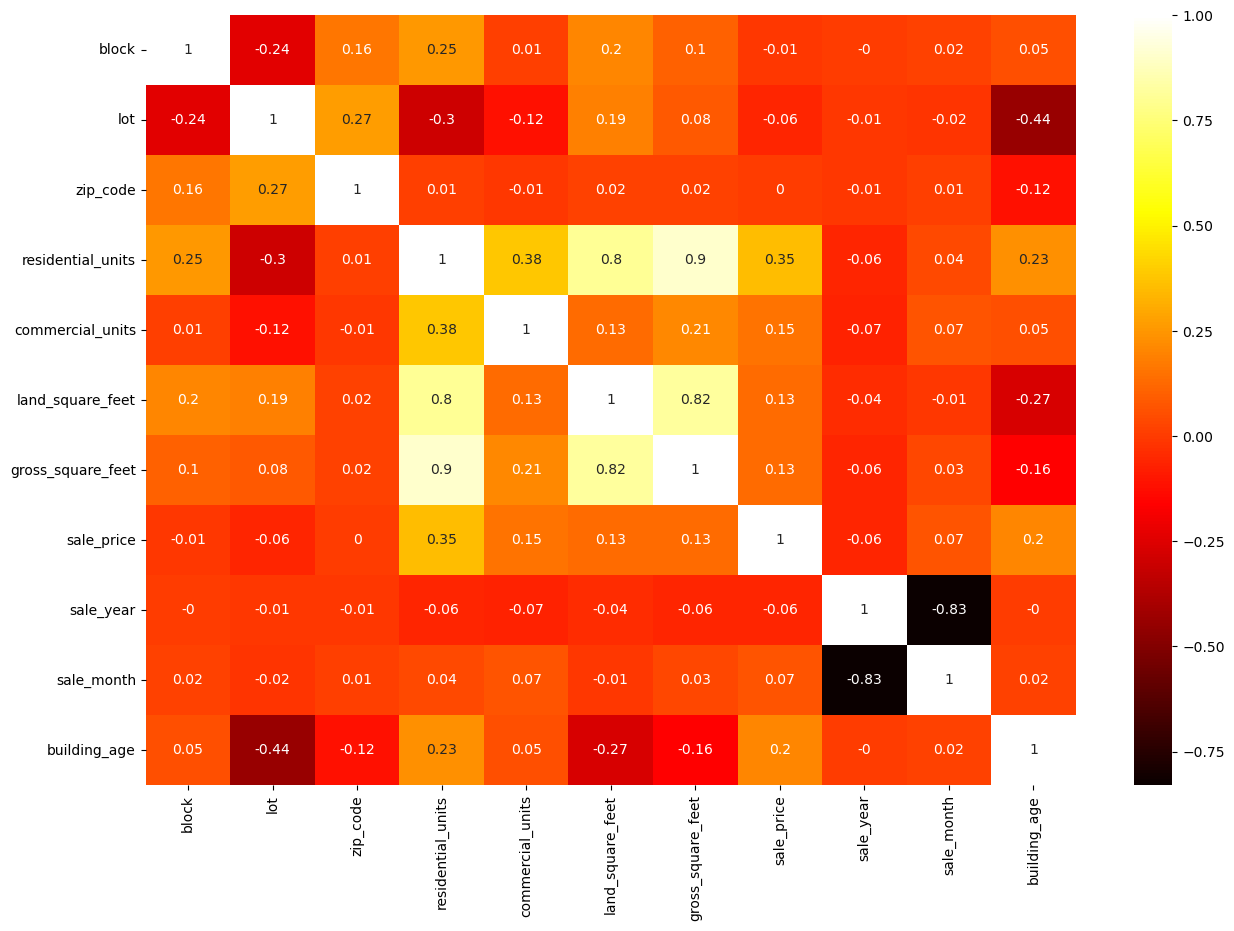

In [25]:
plt.figure(figsize=(15, 10))
sns.heatmap(df[numerical].corr().round(2), annot=True, cmap='hot')

In [26]:
X = df.drop(columns='sale_price')
y = df['sale_price']
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10704 entries, 18 to 27386
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   neighborhood             10704 non-null  object 
 1   building_class_category  10704 non-null  object 
 2   block                    10704 non-null  int64  
 3   lot                      10704 non-null  int64  
 4   zip_code                 10704 non-null  float64
 5   residential_units        5067 non-null   float64
 6   commercial_units         618 non-null    float64
 7   land_square_feet         1190 non-null   float64
 8   gross_square_feet        1191 non-null   float64
 9   sale_year                10704 non-null  int64  
 10  sale_month               10704 non-null  int64  
 11  building_age             10704 non-null  float64
dtypes: float64(6), int64(4), object(2)
memory usage: 1.1+ MB


In [27]:
neigborhood_le = LabelEncoder()
building_class_category = LabelEncoder()
X['encoded_neighborhood'] = neigborhood_le.fit_transform(X['neighborhood'])
X['encoded_building_class_category'] = neigborhood_le.fit_transform(X['building_class_category'])
X.drop(columns=['building_class_category', 'neighborhood'], inplace=True)
final_columns = X.columns

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [29]:
X_test = pd.DataFrame(X_test, columns=final_columns)
X_train = pd.DataFrame(X_train, columns=final_columns)

In [30]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [31]:
final_columns = train.columns

In [32]:
train.isnull().sum()

block                                 0
lot                                   0
zip_code                              0
residential_units                  4535
commercial_units                   8063
land_square_feet                   7620
gross_square_feet                  7618
sale_year                             0
sale_month                            0
building_age                          0
encoded_neighborhood                  0
encoded_building_class_category       0
sale_price                            0
dtype: int64

In [33]:
le = LinearRegression()
imputer = IterativeImputer(estimator=le, min_value=train.min())
imputer.fit(train)
train = pd.DataFrame(imputer.transform(train), columns=final_columns)
test = pd.DataFrame(imputer.transform(test), columns=final_columns)

In [34]:
train[['commercial_units', 'residential_units']] = train[['commercial_units', 'residential_units']].applymap(lambda x: round(x))
test[['commercial_units', 'residential_units']] = test[['commercial_units', 'residential_units']].applymap(lambda x: round(x))

In [35]:
train.describe()

,block,lot,zip_code,residential_units,commercial_units,land_square_feet,gross_square_feet,sale_year,sale_month,building_age,encoded_neighborhood,encoded_building_class_category,sale_price
count,8563.000000,8563.00000,8563.000000,8563.000000,8563.000000,8563.000000,8563.000000,8563.000000,8563.000000,8563.000000,8563.000000,8563.000000,8.563000e+03
mean,1095.382927,623.20028,10030.488030,6.270700,1.149831,4637.268162,6363.374891,2012.577017,6.935887,63.512204,21.850286,8.547822,1.954720e+06
std,513.945145,830.48010,38.414494,10.659849,0.768357,3056.294475,11017.201225,0.494062,3.315107,35.373196,11.041459,3.086943,2.098264e+06
min,11.000000,1.00000,10001.000000,1.000000,1.000000,469.000000,999.000000,2012.000000,1.000000,0.000000,0.000000,0.000000,5.019300e+05
25%,764.000000,24.00000,10013.000000,1.000000,1.000000,2799.737176,999.000000,2012.000000,4.000000,33.000000,11.000000,7.000000,7.400000e+05
50%,1171.000000,63.00000,10022.000000,7.000000,1.000000,3670.304312,6849.016317,2013.000000,7.000000,65.000000,25.000000,7.000000,1.175000e+06
75%,1448.000000,1131.00000,10028.000000,9.000000,1.000000,6157.258223,9778.397349,2013.000000,10.000000,93.000000,31.000000,10.000000,2.200000e+06
max,2246.000000,8163.00000,10463.000000,499.000000,47.000000,88940.000000,538213.000000,2013.000000,12.000000,213.000000,37.000000,29.000000,1.490000e+07


In [36]:
test.describe()

,block,lot,zip_code,residential_units,commercial_units,land_square_feet,gross_square_feet,sale_year,sale_month,building_age,encoded_neighborhood,encoded_building_class_category,sale_price
count,2141.000000,2141.000000,2141.000000,2141.000000,2141.000000,2141.000000,2141.000000,2141.000000,2141.000000,2141.000000,2141.000000,2141.000000,2.141000e+03
mean,1101.115367,632.375058,10031.572163,6.385334,1.186362,4668.901222,6422.261586,2012.572630,6.910322,63.450257,22.360579,8.440915,1.994944e+06
std,518.012189,873.140949,40.408013,10.424968,1.397033,2982.013328,10452.729047,0.494812,3.294060,35.726583,10.937153,3.000917,2.106399e+06
min,16.000000,1.000000,10001.000000,1.000000,1.000000,524.000000,999.000000,2012.000000,1.000000,1.000000,0.000000,0.000000,5.025000e+05
25%,738.000000,25.000000,10013.000000,1.000000,1.000000,2800.000000,999.000000,2012.000000,4.000000,32.000000,11.000000,7.000000,7.450000e+05
50%,1182.000000,63.000000,10022.000000,8.000000,1.000000,3638.751262,6845.865114,2013.000000,7.000000,72.000000,26.000000,7.000000,1.195000e+06
75%,1450.000000,1122.000000,10028.000000,9.000000,1.000000,6166.729574,9784.270083,2013.000000,10.000000,93.000000,31.000000,10.000000,2.350000e+06
max,2246.000000,9008.000000,10463.000000,334.000000,60.000000,43500.000000,336543.000000,2013.000000,12.000000,167.000000,37.000000,29.000000,1.471162e+07


In [37]:
train[['encoded_neighborhood', 'encoded_building_class_category']] = train[['encoded_neighborhood', 'encoded_building_class_category']].astype(np.object)

/var/folders/4m/__j4737x1p73lg1hgfht7tnm0000gn/T/ipykernel_37543/4126784561.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train[['encoded_neighborhood', 'encoded_building_class_category']] = train[['encoded_neighborhood', 'encoded_building_class_category']].astype(np.object)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37]),
 [Text(0, 0, '25.0'),
  Text(1, 0, '7.0'),
  Text(2, 0, '18.0'),
  Text(3, 0, '9.0'),
  Text(4, 0, '23.0'),
  Text(5, 0, '20.0'),
  Text(6, 0, '21.0'),
  Text(7, 0, '35.0'),
  Text(8, 0, '26.0'),
  Text(9, 0, '12.0'),
  Text(10, 0, '32.0'),
  Text(11, 0, '34.0'),
  Text(12, 0, '24.0'),
  Text(13, 0, '13.0'),
  Text(14, 0, '10.0'),
  Text(15, 0, '1.0'),
  Text(16, 0, '28.0'),
  Text(17, 0, '8.0'),
  Text(18, 0, '17.0'),
  Text(19, 0, '33.0'),
  Text(20, 0, '4.0'),
  Text(21, 0, '31.0'),
  Text(22, 0, '30.0'),
  Text(23, 0, '5.0'),
  Text(24, 0, '22.0'),
  Text(25, 0, '3.0'),
  Text(26, 0, '0.0'),
  Text(27, 0, '11.0'),
  Text(28, 0, '29.0'),
  Text(29, 0, '6.0'),
  Text(30, 0, '19.0'),
  Text(31, 0, '37.0'),
  Text(32, 0, '14.0'),
  Text(33, 0, '2.0'),
  Text(34, 0, '27.0'),
  Text(35, 0, '16.0'),
  Text(36, 0, 

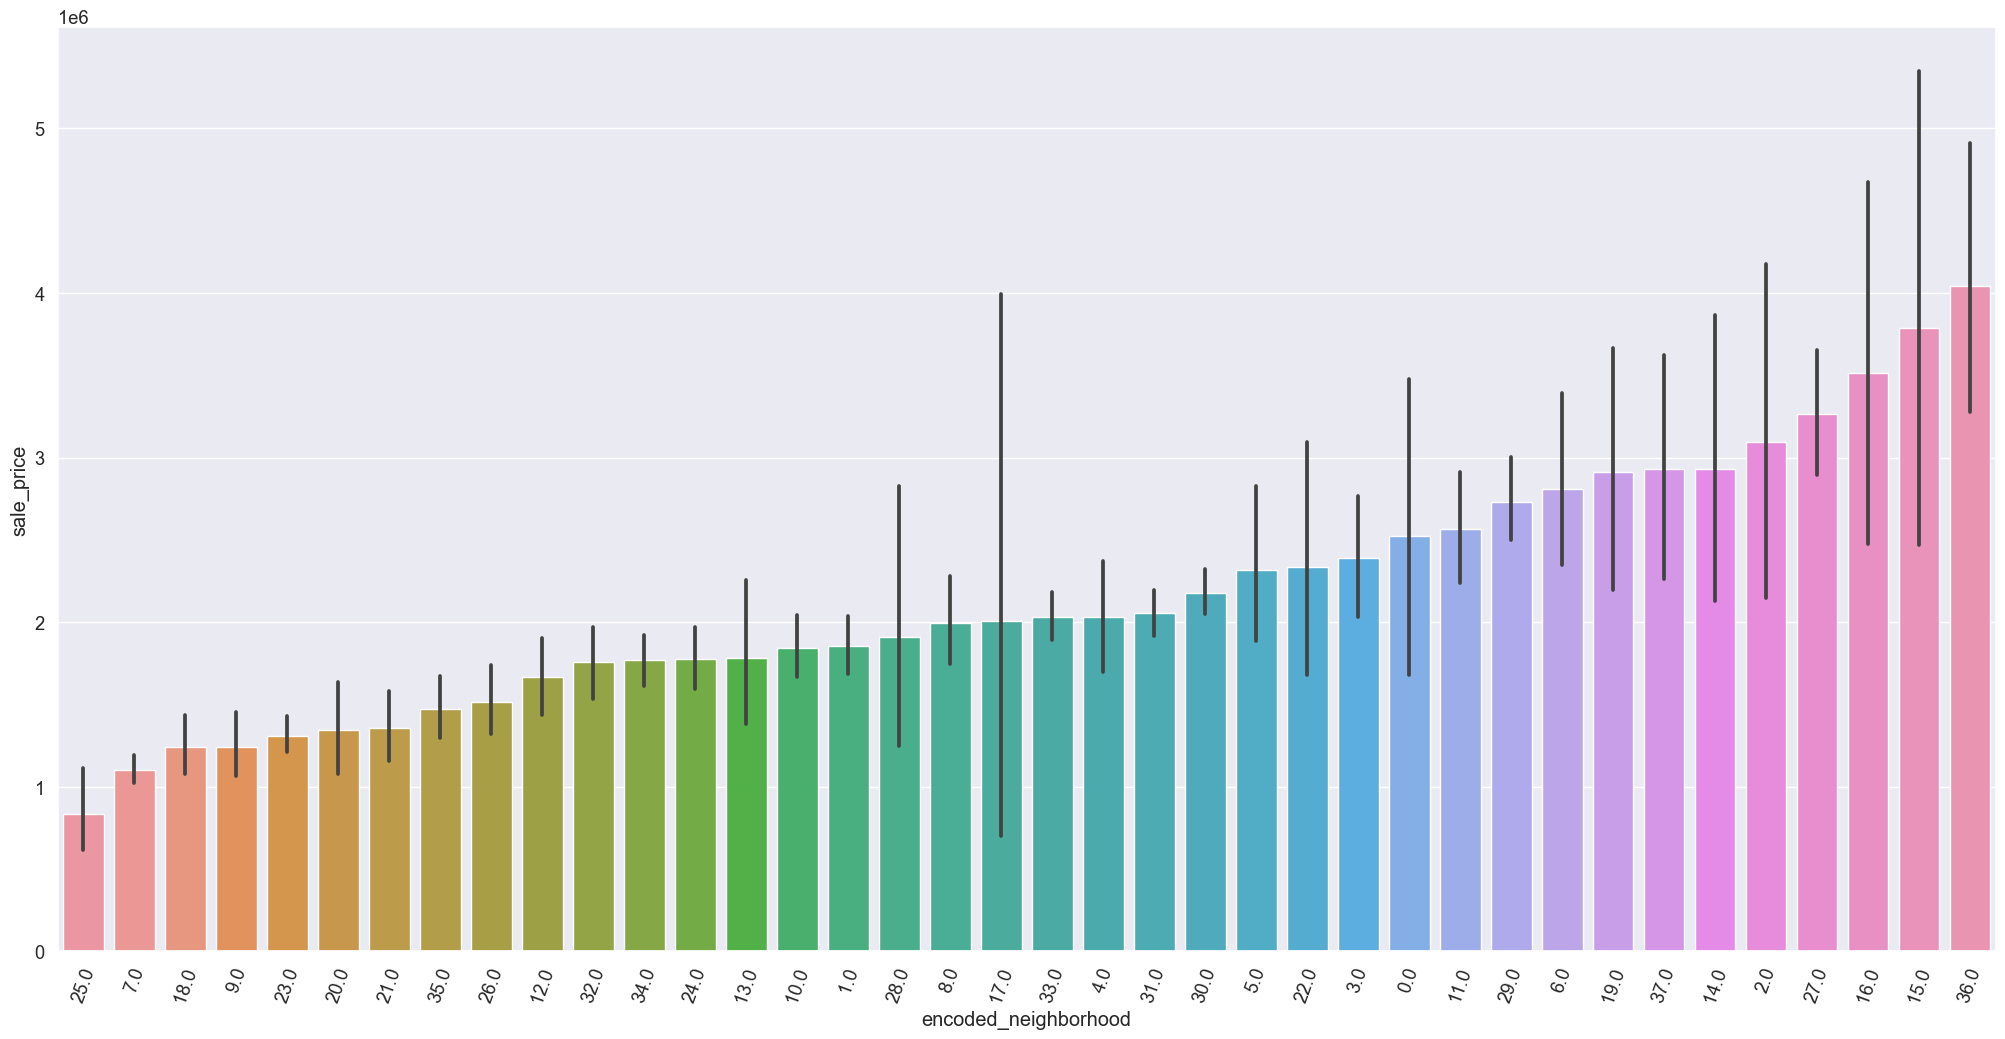

In [38]:
plt.figure(figsize=(25, 12))
sns.set_theme(font_scale=1.2)
fig = sns.barplot(data=train ,y='sale_price', x='encoded_neighborhood', order=train.groupby(['encoded_neighborhood']).mean().sort_values('sale_price').index)
plt.xticks(rotation=70)

In [39]:
train['sale_price'] = np.log(train['sale_price'])
test['sale_price'] = np.log(test['sale_price'])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37]),
 [Text(0, 0, '25.0'),
  Text(1, 0, '9.0'),
  Text(2, 0, '20.0'),
  Text(3, 0, '7.0'),
  Text(4, 0, '18.0'),
  Text(5, 0, '23.0'),
  Text(6, 0, '21.0'),
  Text(7, 0, '26.0'),
  Text(8, 0, '35.0'),
  Text(9, 0, '12.0'),
  Text(10, 0, '13.0'),
  Text(11, 0, '17.0'),
  Text(12, 0, '10.0'),
  Text(13, 0, '24.0'),
  Text(14, 0, '22.0'),
  Text(15, 0, '34.0'),
  Text(16, 0, '1.0'),
  Text(17, 0, '0.0'),
  Text(18, 0, '28.0'),
  Text(19, 0, '33.0'),
  Text(20, 0, '31.0'),
  Text(21, 0, '4.0'),
  Text(22, 0, '32.0'),
  Text(23, 0, '8.0'),
  Text(24, 0, '30.0'),
  Text(25, 0, '5.0'),
  Text(26, 0, '11.0'),
  Text(27, 0, '37.0'),
  Text(28, 0, '14.0'),
  Text(29, 0, '3.0'),
  Text(30, 0, '6.0'),
  Text(31, 0, '2.0'),
  Text(32, 0, '29.0'),
  Text(33, 0, '19.0'),
  Text(34, 0, '27.0'),
  Text(35, 0, '16.0'),
  Text(36, 0, 

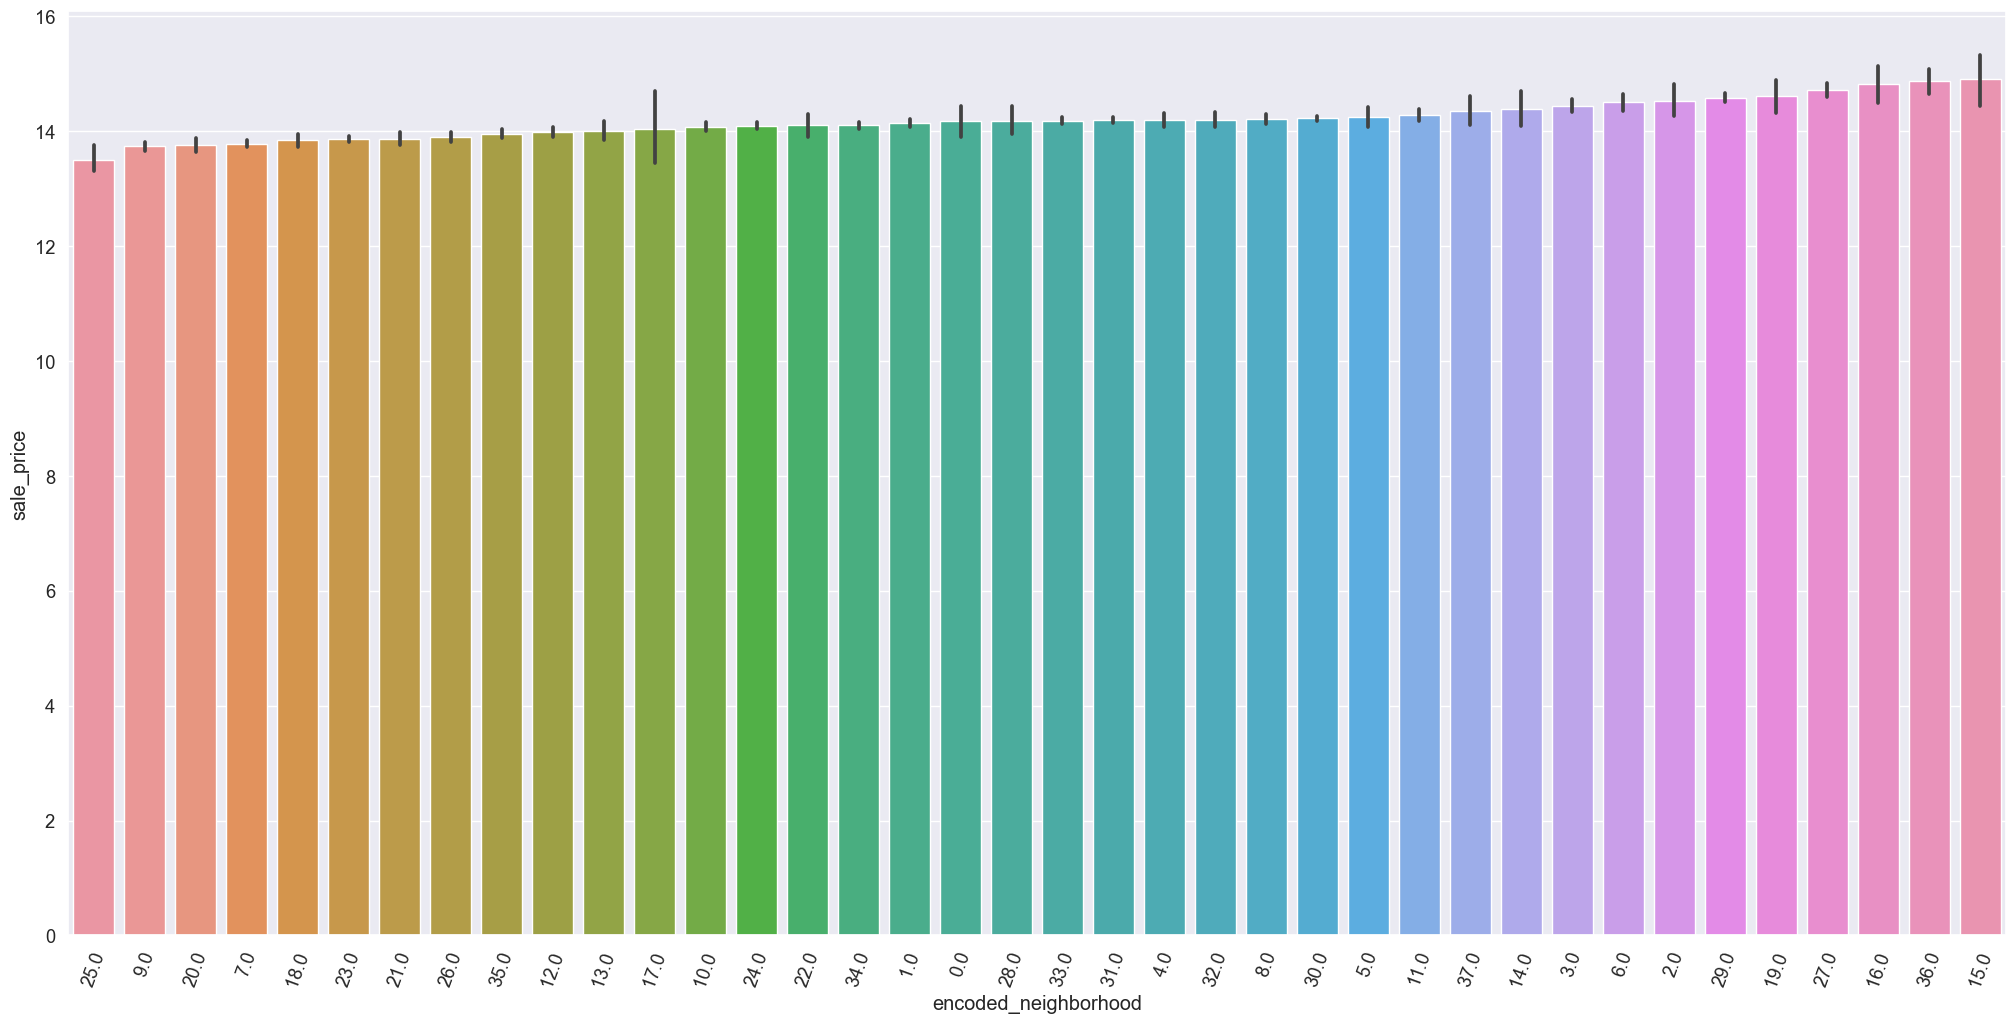

In [40]:
plt.figure(figsize=(25, 12))
sns.set_theme(font_scale=1.2)
fig = sns.barplot(data=train ,y='sale_price', x='encoded_neighborhood', order=train.groupby(['encoded_neighborhood']).mean().sort_values('sale_price').index)
plt.xticks(rotation=70)

In [41]:
neigborhood_le.classes_

array(['01  ONE FAMILY HOMES', '02  TWO FAMILY HOMES',
       '03  THREE FAMILY HOMES', '04  TAX CLASS 1 CONDOS',
       '07  RENTALS - WALKUP APARTMENTS',
       '08  RENTALS - ELEVATOR APARTMENTS',
       '09  COOPS - WALKUP APARTMENTS', '10  COOPS - ELEVATOR APARTMENTS',
       '11A CONDO-RENTALS', '12  CONDOS - WALKUP APARTMENTS',
       '13  CONDOS - ELEVATOR APARTMENTS', '14  RENTALS - 4-10 UNIT',
       '15  CONDOS - 2-10 UNIT RESIDENTIAL',
       '16  CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT', '17  CONDOPS',
       '21  OFFICE BUILDINGS', '22  STORE BUILDINGS',
       '23  LOFT BUILDINGS', '26  OTHER HOTELS', '27  FACTORIES',
       '28  COMMERCIAL CONDOS', '29  COMMERCIAL GARAGES',
       '30  WAREHOUSES', '31  COMMERCIAL VACANT LAND',
       '32  HOSPITAL AND HEALTH FACILITIES', '33  EDUCATIONAL FACILITIES',
       '35  INDOOR PUBLIC AND CULTURAL FACILITIES',
       '37  RELIGIOUS FACILITIES', '38  ASYLUMS AND HOMES',
       '41  TAX CLASS 4 - OTHER'], dtype=object)

<AxesSubplot: >

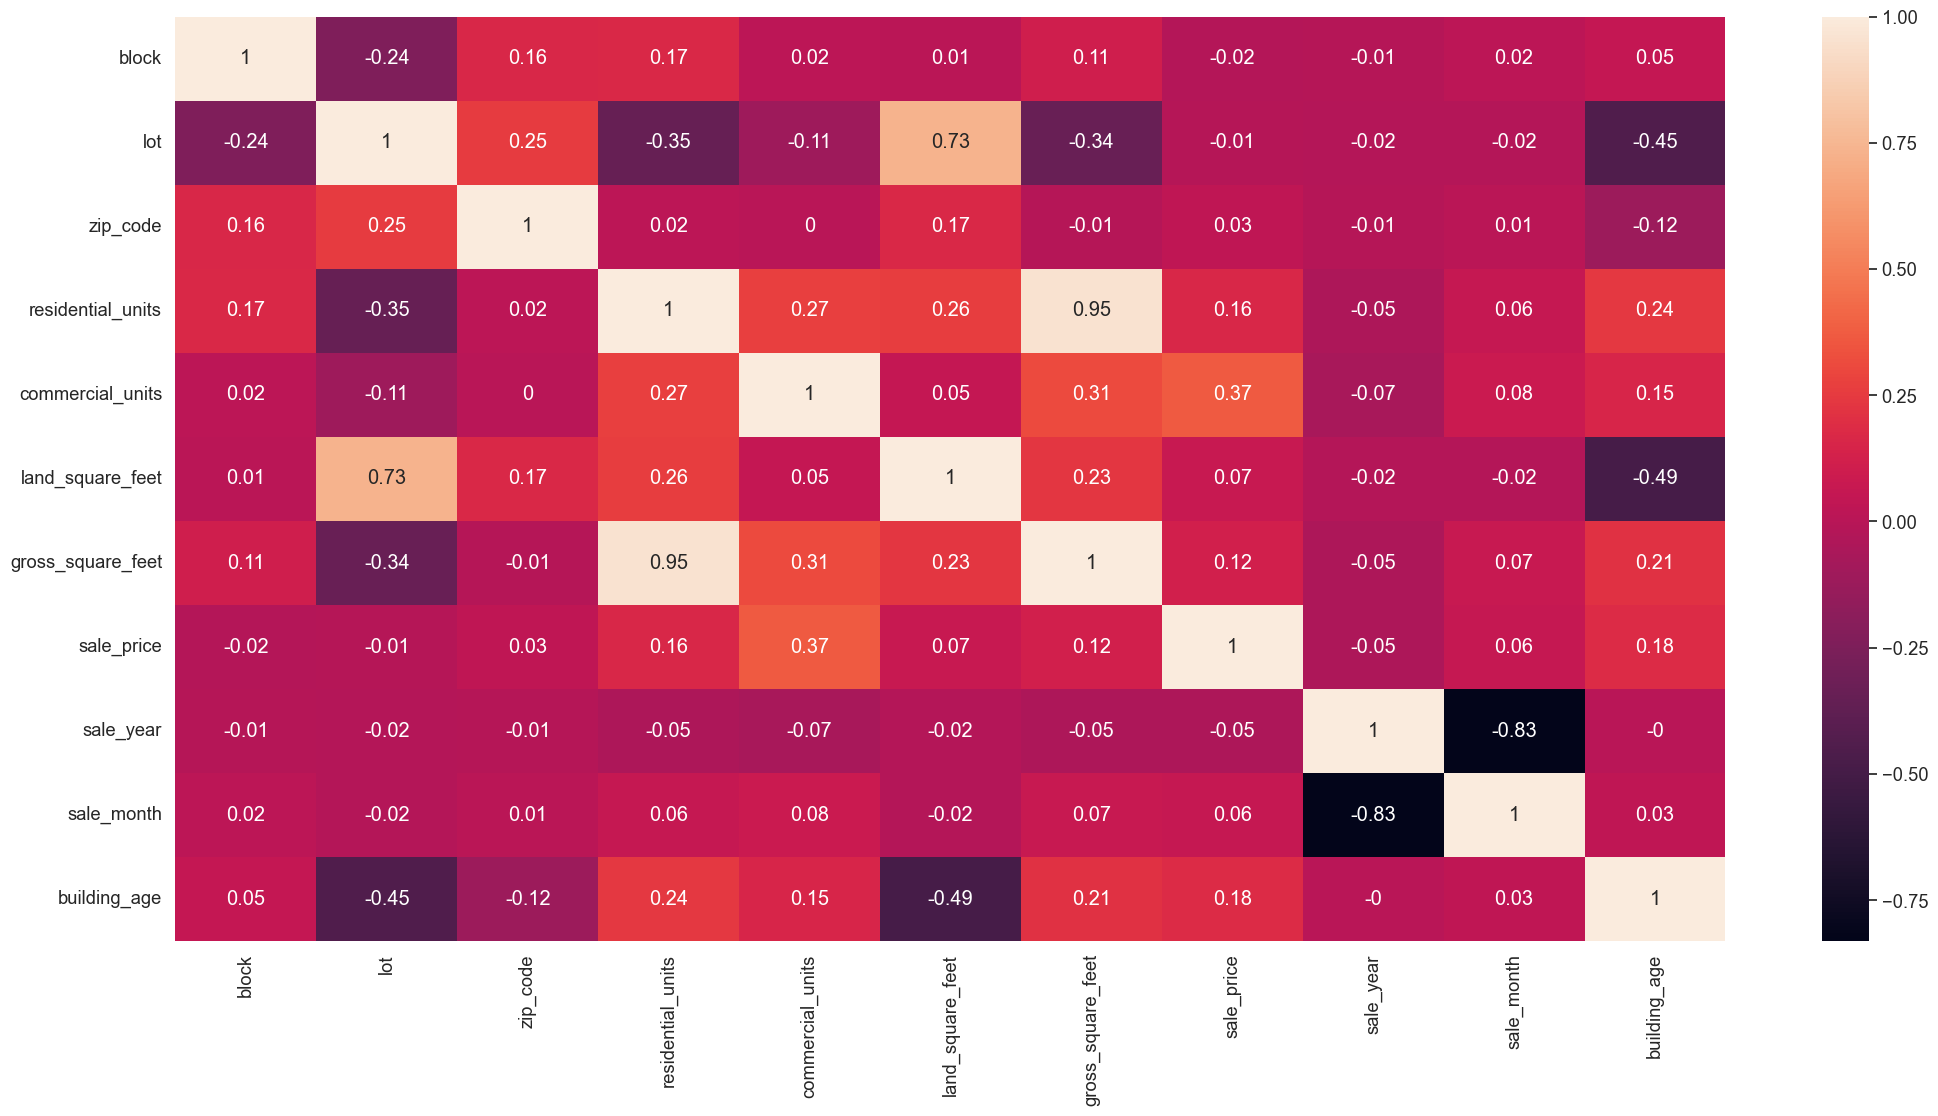

In [42]:
plt.figure(figsize=(25, 12))
sns.set_theme(font_scale=1.2)
sns.heatmap(train[numerical].corr().round(2), annot=True)

In [43]:
train[['encoded_neighborhood', 'encoded_building_class_category']] = train[['encoded_neighborhood', 'encoded_building_class_category']].astype(np.int)

/var/folders/4m/__j4737x1p73lg1hgfht7tnm0000gn/T/ipykernel_37543/3045113583.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train[['encoded_neighborhood', 'encoded_building_class_category']] = train[['encoded_neighborhood', 'encoded_building_class_category']].astype(np.int)


In [44]:
Q1 = train.quantile(0.25)
Q3 = train.quantile(0.75)
IQR = Q3 - Q1
train = train[~((train < (Q1 - 1.5 * IQR)) |(train > (Q3 + 1.5 * IQR))).any(axis=1)]
'''
Zolduoarrati, E. (2019, December 17). Remove Outliers in Pandas DataFrame using Percentiles. Stack Overflow. https://stackoverflow.com/questions/35827863/remove-outliers-in-pandas-dataframe-using-percentiles
'''

'\nZolduoarrati, E. (2019, December 17). Remove Outliers in Pandas DataFrame using Percentiles. Stack Overflow. https://stackoverflow.com/questions/35827863/remove-outliers-in-pandas-dataframe-using-percentiles\n'

In [45]:
numerical.extend(['encoded_neighborhood', 'encoded_building_class_category'])

In [46]:
train.shape

(6360, 13)

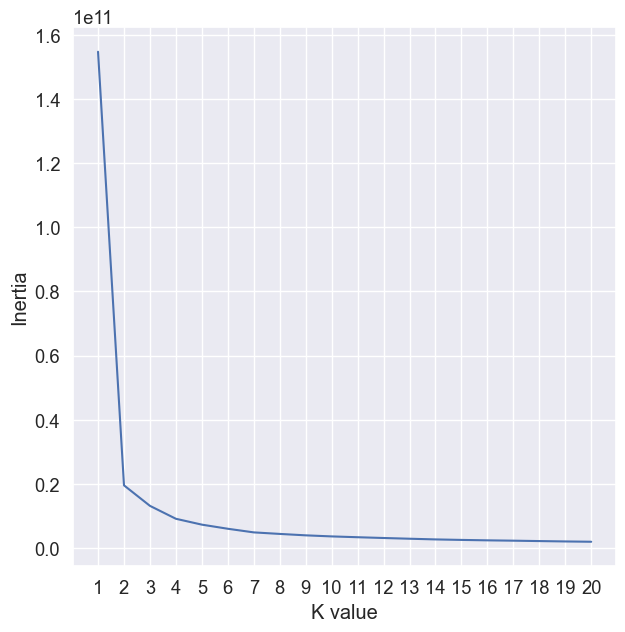

{1: 154699197809.37286, 2: 19525347741.323093, 3: 13132086192.679745, 4: 9101842290.275146, 5: 7273951518.296493, 6: 5990289239.070831, 7: 4860767231.073296, 8: 4380900646.086611, 9: 3939832692.8980565, 10: 3604471560.9008055, 11: 3352107540.9661565, 12: 3110885050.737789, 13: 2883204299.9760556, 14: 2668061548.8985615, 15: 2511832360.304304, 16: 2381251263.3817306, 17: 2274364804.6631203, 18: 2151430248.128456, 19: 2035167114.5179954, 20: 1940767018.193762}


In [47]:
sse = {}
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(train)
    sse[k] = kmeans.inertia_

plt.figure(figsize=(7, 7))
sns.lineplot(x=range(1, 21), y=sse.values())
plt.xticks(ticks=(range(1, 21)))
plt.xlabel("K value")
plt.ylabel("Inertia")
plt.show()
print(sse)

In [48]:
number_of_clusters = 2

k_means_model = KMeans(n_clusters=number_of_clusters, random_state=69420)

In [49]:
y = k_means_model.fit_transform(train)

In [50]:
train['label'] = k_means_model.labels_

<AxesSubplot: xlabel='label', ylabel='Count'>

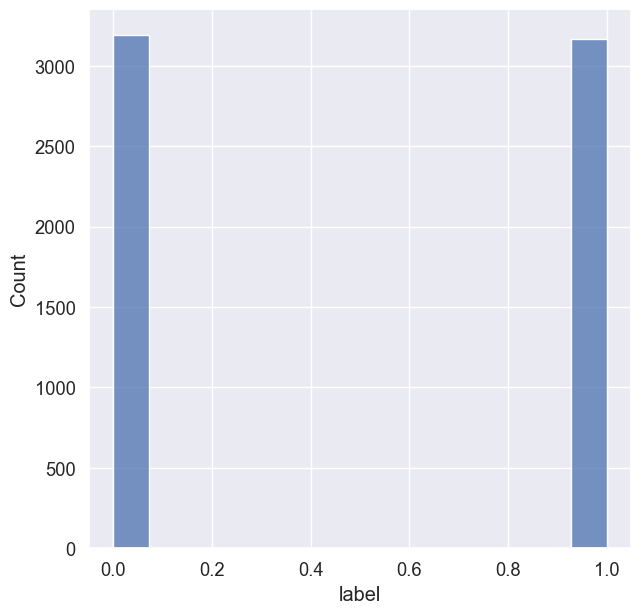

In [59]:
plt.figure(figsize=(7, 7))
sns.histplot(data=train, x='label')

,block,lot,zip_code,residential_units,commercial_units,land_square_feet,gross_square_feet,sale_year,sale_month,building_age,encoded_neighborhood,encoded_building_class_category,sale_price
label,,,,,,,,,,,,,
0,946.781710,1205.712809,10018.581898,1.143439,1.0,6040.367508,1054.479171,2012.584717,6.769183,46.568744,18.472909,10.421547,14.017442
1,1118.165772,29.826334,10018.393432,9.092832,1.0,2913.585171,9646.722268,2012.613514,6.798548,75.451531,22.924219,6.837070,13.859298
